In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

In [2]:
# System
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


In [ ]:
# --- 1. Configuration ---
# Data and Feature Engineering
WINDOW_SIZE = 30
TS_COLS = [str(i) for i in range(1, 501)]

# VAE Model Architecture
INPUT_DIM = WINDOW_SIZE              
VAE_HIDDEN_DIM = 512                 
VAE_PRE_LATENT_DIM = 256             
VAE_LATENT_DIM = 64                  

# Training Hyperparameters
N_EPOCHS = 100                       
BATCH_SIZE = 32
LEARNING_RATE = 1e-4                 
BETA = 1                       
                                     
# Anomaly Detection
THRESHOLD_STD_MULTIPLIER = 3  # Refined: Use Mean + 3*STD for thresholding
CONSECUTIVE_WINDOW_THRESHOLD = 3 # Refined: Require 3 consecutive windows to trigger an anomaly
NORMAL_RUNS_TO_PLOT = 3  # New: Number of normal runs to plot for sanity check

In [4]:
# --- 3. Data Loading & Feature Engineering ---
try:
    normal_df_raw = pd.read_csv("data/transform/pivot_normal_conductivity.csv",
                                index_col=False)
    anomaly_df_raw = pd.read_csv(
        "data/transform/pivot_anomaly_conductivity.csv", index_col=False)
except FileNotFoundError as e:
    print(
        f"Error loading data: {e}. Make sure the CSV files are in the correct directory.")
    exit()

normal_df = normal_df_raw[
    normal_df_raw['metric'] == 'conductivity'].reset_index(drop=True)
anomaly_df = anomaly_df_raw[
    anomaly_df_raw['metric'] == 'conductivity'].reset_index(drop=True)

In [5]:
normal_df

,run_id,metric,1,2,3,4,5,6,7,8,...,491,492,493,494,495,496,497,498,499,500
0,JUL_22_1,conductivity,56.32,56.17,56.32,56.17,56.17,56.39,56.32,56.39,...,56.17,56.10,56.17,56.11,56.10,56.10,56.10,56.03,56.11,56.32
1,JUL_22_2,conductivity,56.24,56.03,56.03,56.03,56.03,55.83,56.25,56.24,...,56.03,56.03,56.25,56.25,56.25,56.24,56.32,56.10,56.11,56.32
2,JUL_22_4,conductivity,55.95,55.81,55.83,55.97,55.97,55.97,55.75,55.75,...,55.75,55.75,55.83,55.81,55.81,55.75,55.75,55.75,55.75,55.83
3,JUL_22_5,conductivity,55.75,55.81,55.81,55.75,55.83,55.75,55.61,55.75,...,55.61,55.75,55.61,55.69,55.61,55.55,55.56,55.55,55.53,55.61
4,JUL_22_7,conductivity,56.24,56.32,56.46,56.24,56.46,56.46,56.38,56.41,...,56.24,56.17,56.24,56.17,56.17,56.17,56.03,56.17,56.17,56.03
5,NOV_5_1,conductivity,55.75,55.96,55.67,55.96,55.67,55.67,55.96,55.67,...,55.89,55.81,55.89,56.04,55.81,56.04,55.89,55.83,56.04,55.89
6,NOV_5_2,conductivity,56.30,56.10,56.02,56.38,56.30,56.45,56.30,56.30,...,56.24,56.30,56.24,56.24,56.24,56.24,56.24,56.30,56.30,56.30
7,NOV_5_3,conductivity,56.30,56.16,56.15,56.15,56.23,56.23,56.37,56.37,...,56.23,56.37,56.23,56.37,56.37,56.29,56.37,56.37,56.29,56.37
8,NOV_5_4,conductivity,56.21,56.21,56.21,56.13,56.13,56.13,56.21,56.21,...,56.37,56.37,56.29,56.35,56.29,56.29,56.35,56.21,56.15,56.37
9,NOV_5_5,conductivity,56.37,56.51,56.45,56.45,56.45,56.37,56.45,56.37,...,56.45,56.45,56.59,56.45,56.59,56.51,56.51,56.51,56.45,56.45


In [6]:
anomaly_df

,run_id,metric,1,2,3,4,5,6,7,8,...,491,492,493,494,495,496,497,498,499,500
0,JUL_22_3,conductivity,58.14,58.28,58.14,58.08,58.22,58.08,58.22,58.22,...,58.14,58.14,58.14,58.36,58.34,58.14,58.14,58.14,58.14,58.14
1,JUL_22_6,conductivity,55.47,55.55,55.58,55.55,55.55,55.53,55.51,55.47,...,55.53,55.67,55.51,55.47,55.61,55.61,55.61,55.61,55.61,55.61
2,JUL_23_4,conductivity,57.57,57.43,57.64,57.64,57.64,57.50,57.50,57.42,...,58.27,58.33,58.27,58.12,58.27,58.12,58.34,58.41,58.34,58.41
3,JUL_23_5,conductivity,58.55,58.55,58.55,58.55,58.55,58.55,58.55,58.61,...,58.69,58.69,58.69,58.69,58.69,58.69,58.69,58.69,58.69,58.69
4,JUL_24_3,conductivity,56.74,56.88,56.87,56.87,56.88,56.88,56.88,56.88,...,57.01,57.01,56.80,57.01,56.80,56.80,57.01,56.80,56.80,57.01
5,OCT_24_4,conductivity,56.69,56.81,56.75,56.75,56.75,56.75,56.69,56.75,...,56.81,57.17,57.17,56.81,57.03,57.03,56.75,57.03,57.24,56.75


In [7]:
normal_train_runs, normal_val_runs = train_test_split(normal_df,
                                                      test_size=0.2,
                                                      random_state=42)

In [8]:
def create_windows_from_featured_df(df, ts_cols, window_size):
    windows = []
    for i in range(len(df)):
        raw_series = df.iloc[i][ts_cols].values
        for j in range(len(raw_series) - window_size + 1):
            raw_window = raw_series[j:j + window_size]
            windows.append(raw_window)

    return np.array(windows)

train_windows = create_windows_from_featured_df(normal_train_runs, TS_COLS, WINDOW_SIZE)
val_windows = create_windows_from_featured_df(normal_val_runs, TS_COLS, WINDOW_SIZE)

In [9]:
print(f"Train window shape: {train_windows.shape}")
print(f"Validation window shape: {val_windows.shape}")

Train window shape: (5652, 30)
Validation window shape: (1413, 30)


In [10]:
# --- 5. Scaling ---
scaler = MinMaxScaler()
scaler.fit(train_windows)
train_windows_scaled = scaler.transform(train_windows)
val_windows_scaled = scaler.transform(val_windows)
print("Data scaling complete.")

Data scaling complete.


In [11]:
# --- 6. PyTorch Datasets and DataLoaders ---

class TimeSeriesWindowDataset(Dataset):
    def __init__(self, windows_data):
        self.data = torch.tensor(windows_data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


train_dataset = TimeSeriesWindowDataset(train_windows_scaled)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TimeSeriesWindowDataset(val_windows_scaled)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
# --- 7. VAE Model Definition ---
class VAE(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, hidden_dim=VAE_HIDDEN_DIM,
                 pre_latent_dim=VAE_PRE_LATENT_DIM,
                 actual_latent_dim=VAE_LATENT_DIM, device=DEVICE):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, pre_latent_dim),
            nn.LeakyReLU(0.2)
        )
        self.mean_layer = nn.Linear(pre_latent_dim, actual_latent_dim)
        self.logvar_layer = nn.Linear(pre_latent_dim, actual_latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(actual_latent_dim, pre_latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(pre_latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean = self.mean_layer(x)
        log_var = self.logvar_layer(x)
        return mean, log_var

    def reparameterization(self, mean, log_var):
        epsilon = torch.randn_like(log_var).to(DEVICE)
        return mean + torch.exp(log_var / 2) * epsilon

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        return self.decoder(z), mean, log_var

In [13]:
# --- 8. Training Components ---

def vae_loss(recon_x, x, mu, logvar, beta=BETA):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss + (beta * kld)) / x.size(0)


def train_epoch(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    for x in dataloader:
        x = x.to(DEVICE)
        optimizer.zero_grad()
        x_hat, mu, log_var = model(x)
        loss = vae_loss(x_hat, x, mu, log_var)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def val_epoch(model, dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in dataloader:
            x = x.to(DEVICE)
            x_hat, mu, log_var = model(x)
            loss = vae_loss(x_hat, x, mu, log_var)
            total_loss += loss.item()
    return total_loss / len(dataloader)


--- Starting VAE Training ---
Epoch 010/100 | Train Loss: 0.903247 | Val Loss: 1.343828
Epoch 020/100 | Train Loss: 0.894245 | Val Loss: 1.296136
Epoch 030/100 | Train Loss: 0.858488 | Val Loss: 1.374187
Epoch 040/100 | Train Loss: 0.888501 | Val Loss: 1.363513
Epoch 050/100 | Train Loss: 0.892149 | Val Loss: 1.346305
Epoch 060/100 | Train Loss: 0.891057 | Val Loss: 1.326942
Epoch 070/100 | Train Loss: 0.848313 | Val Loss: 1.375799
Epoch 080/100 | Train Loss: 0.878521 | Val Loss: 1.356629
Epoch 090/100 | Train Loss: 0.863536 | Val Loss: 1.335429
Epoch 100/100 | Train Loss: 0.835645 | Val Loss: 1.270817
--- Training Complete ---


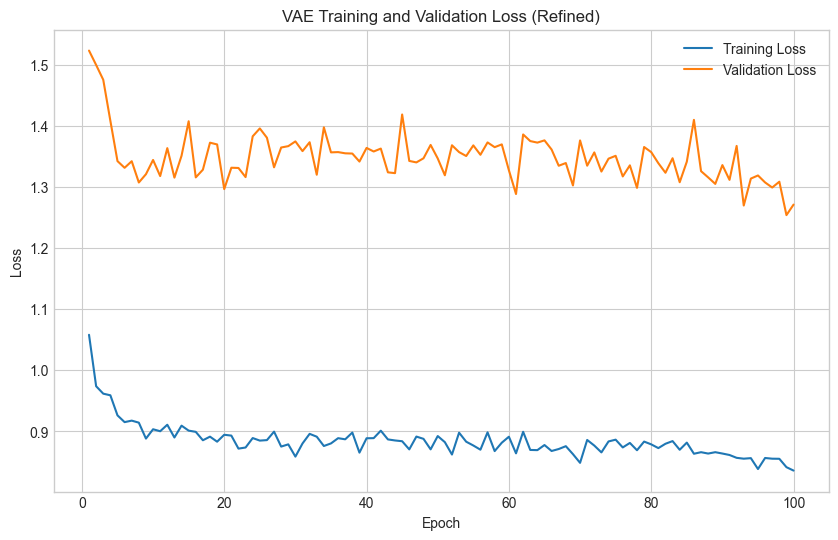

In [25]:
# --- 9. Model Training ---
model = VAE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_losses, val_losses = [], []

print("\n--- Starting VAE Training ---")
for epoch in range(N_EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer)
    val_loss = val_epoch(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch + 1:03d}/{N_EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

print("--- Training Complete ---")
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, N_EPOCHS + 1), val_losses, label='Validation Loss')
plt.title('VAE Training and Validation Loss (Refined)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Calculating reconstruction errors on normal validation windows to set threshold...
Anomaly Threshold (95.0th Quantile): 0.079581

Using threshold: 0.079581



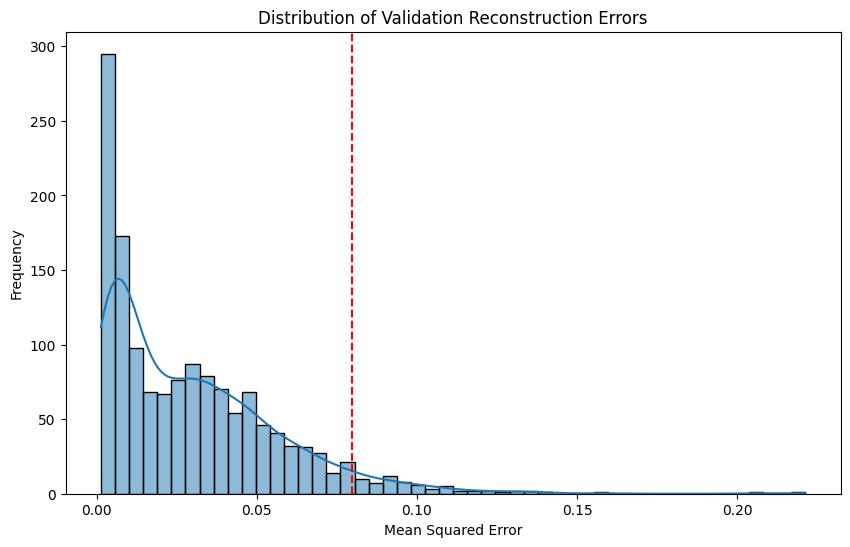

In [ ]:
# --- 10. Anomaly Thresholding ---
def get_reconstructions_and_errors(model, dataloader):
    model.eval()
    all_reconstructions = []
    all_errors = []
    with torch.no_grad():
        for x in dataloader:
            x = x.to(DEVICE)
            x_hat, _, _ = model(x)
            errors = F.mse_loss(x_hat, x, reduction='none').mean(dim=1)
            all_errors.extend(errors.cpu().numpy())
            all_reconstructions.extend(x_hat.cpu().numpy())
    return np.array(all_reconstructions), np.array(all_errors)

print("Calculating reconstruction errors on normal validation windows to set threshold...")
_, val_errors = get_reconstructions_and_errors(model, val_loader)

QUANTILE = 0.95
threshold_quantile = np.quantile(val_errors, QUANTILE)
print(f"Anomaly Threshold ({QUANTILE*100}th Quantile): {threshold_quantile:.6f}")
threshold = threshold_quantile
print(f"\nUsing threshold: {threshold:.6f}\n")

# --- Plot a histogram of the errors ---
plt.figure(figsize=(10, 6))
sns.histplot(val_errors, bins=50, kde=True)
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Distribution of Validation Reconstruction Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.show()

In [33]:
def reconstruct_full_signal_from_windows(windows, original_length,
                                         window_size):
    raw_signal_windows = windows[:, :window_size]
    reconstructed_signal = np.zeros(original_length)
    window_counts = np.zeros(original_length)

    for i, window in enumerate(raw_signal_windows):
        start_index = i
        end_index = start_index + window_size
        if start_index >= original_length:
            break

        current_window_length = min(window_size,
                                    original_length - start_index)
        reconstructed_signal[start_index:end_index] += window[
                                                       :current_window_length]
        window_counts[start_index:end_index] += 1

    window_counts[window_counts == 0] = 1
    return reconstructed_signal / window_counts

def plot_reconstruction_and_errors(original_signal, run_id,
                                   reconstructed_windows, window_errors,
                                   threshold, anomalous_points_mask,
                                   ground_truth_mask=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

    reconstructed_signal = reconstruct_full_signal_from_windows(
        reconstructed_windows, len(original_signal), WINDOW_SIZE)

    # --- Plot 1: Original vs. Reconstructed Signal (No changes) ---
    ax1.plot(original_signal, label='Original Signal', color='blue', alpha=0.8)
    ax1.plot(reconstructed_signal, label='Reconstructed Signal', color='red',
             linestyle='--')
    highlight_signal = np.where(anomalous_points_mask, original_signal,
                                np.nan)
    ax1.plot(highlight_signal, color='orange', linewidth=4,
             label='Detected Anomalous Region')

    if ground_truth_mask is not None:
        highlight_ground_truth = np.where(ground_truth_mask, original_signal,
                                          np.nan)
        ax1.plot(highlight_ground_truth, color='green', linewidth=2,
                 linestyle=':', label='Ground Truth Anomaly')

    ax1.set_title(f'Run ID: {run_id} - Original vs. Reconstruction',
                  fontsize=16)
    ax1.set_ylabel('Conductivity')
    ax1.legend(loc='upper left')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    # --- Plot 2: Reconstruction Error (MODIFIED) ---
    ax2.plot(window_errors, label='Reconstruction Error per Window',
             color='purple')
    ax2.axhline(y=threshold, color='black', linestyle='-.',
                label=f'Anomaly Threshold ({threshold:.4f})')
    ax2.set_xlabel('Window Start Index')
    ax2.set_ylabel('Mean Squared Error')
    
    # (Your code already had this, but now it will work)
    # ax2.set_ylim(bottom=0) 
    
    # 3. ADD MAJOR TICKS
    # This will create ~5 major, evenly-spaced linear ticks (e.g., 0, 0.02, 0.04, 0.06...)
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=5, prune='lower')) 
    # --- END OF FIXES ---

    ax2.legend(loc='upper left')
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.suptitle(f'Anomaly Detection Analysis for Run: {run_id}', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# --- ADD THIS NEW FUNCTION (COPIED FROM plot_anomalies_example.py) ---
def plot_anomalies(original_signal, is_anomalous_mask, run_id, 
                   y_label="Conductivity", 
                   x_label="Time Step (2s interval)"):
    """
    Creates a plot to visualize time series anomalies, similar to the provided image.

    Args:
        original_signal (array-like): 
            The 1D array or list containing the full time series data (e.g., conductivity values).
        
        is_anomalous_mask (array-like): 
            A 1D boolean array or list of the *same length* as original_signal.
            Should be `True` at indices where an anomaly is detected and `False` otherwise.
        
        run_id (str): 
            The ID of the run, used for the plot title (e.g., "JUL_23_5").
        
        y_label (str, optional): 
            The label for the y-axis. Defaults to "Conductivity".
        
        x_label (str, optional): 
            The label for the x-axis. Defaults to "Time Step (2s interval)".
    """
    
    # Ensure data is in NumPy array format for easier manipulation
    original_signal = np.asarray(original_signal)
    is_anomalous_mask = np.asarray(is_anomalous_mask)
    
    if len(original_signal) != len(is_anomalous_mask):
        raise ValueError("original_signal and is_anomalous_mask must have the same length.")
        
    # Create the time-step axis
    time_steps = np.arange(len(original_signal))
    
    # --- Create the plot ---
    fig, ax = plt.subplots(figsize=(16, 7))
    
    # 1. Plot the original signal as a blue line
    #    zorder=1 places it "behind" the anomaly points.
    ax.plot(time_steps, original_signal, color='blue', label='Normal Data', zorder=1)
    
    # 2. Create the anomaly data
    #    We create an array full of np.nan (which don't get plotted)
    #    and then fill in the *actual signal values* only where the mask is True.
    anomalous_points = np.full_like(original_signal, np.nan, dtype=float)
    anomalous_points[is_anomalous_mask] = original_signal[is_anomalous_mask]
    
    # 3. Plot the anomalies as red circles
    #    This will only plot the non-nan values.
    #    zorder=2 places them "on top" of the line.
    ax.scatter(time_steps, anomalous_points, color='red', label='Anomaly', zorder=2)
    
    # --- Set labels and title ---
    ax.set_title(f"Anomalies Detected in Run: {run_id}", fontsize=16)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    
    # --- Add legend and grid ---
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # --- Display the plot ---
    plt.tight_layout()
    plt.show() # We will call plt.show() from the main script loop

In [29]:
def plot_anomalies_stitched(original_signal, 
                            predicted_mask, 
                            ground_truth_mask,
                            title,
                            x_label="Time Step"):
    """
    Creates a single plot for a long, stitched time series, showing the signal,
    predicted anomalies (Red X), and ground truth anomalies (Green O).
    """
    
    # Ensure data is in NumPy array format
    original_signal = np.asarray(original_signal)
    predicted_mask = np.asarray(predicted_mask)
    ground_truth_mask = np.asarray(ground_truth_mask)
        
    # Create the time-step axis
    time_steps = np.arange(len(original_signal))
    
    # --- Create the plot ---
    fig, ax = plt.subplots(figsize=(25, 8)) # Make it nice and wide
    
    # 1. Plot the original signal as a blue line
    ax.plot(time_steps, original_signal, color='blue', label='Signal', zorder=1, alpha=0.7)
    
    # 2. Create and plot the PREDICTED anomaly data (Red X)
    predicted_points = np.full_like(original_signal, np.nan, dtype=float)
    predicted_points[predicted_mask] = original_signal[predicted_mask]
    
    ax.scatter(time_steps, predicted_points, 
               color='red', 
               label='Predicted Anomaly (VAE)', 
               marker='x', 
               s=20,      
               zorder=3)   
               
    # 3. Create and plot the GROUND TRUTH anomaly data (Green O)
    ground_truth_points = np.full_like(original_signal, np.nan, dtype=float)
    ground_truth_points[ground_truth_mask] = original_signal[ground_truth_mask]
            
    ax.scatter(time_steps, ground_truth_points, 
                color='green', 
                label='Ground Truth Anomaly',
                marker='o',       
                s=50,            
                zorder=2,         
                alpha=0.5)        

    # --- Set labels and title ---
    ax.set_title(title, fontsize=16)
    ax.set_ylabel("Conductivity", fontsize=12)
    ax.set_xlabel(x_label, fontsize=12)
    
    # --- Add legend and grid ---
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper left')
    
    # --- Display the plot ---
    plt.tight_layout()

Generating simplified anomaly plot for anomaly run 'JUL_22_3'...


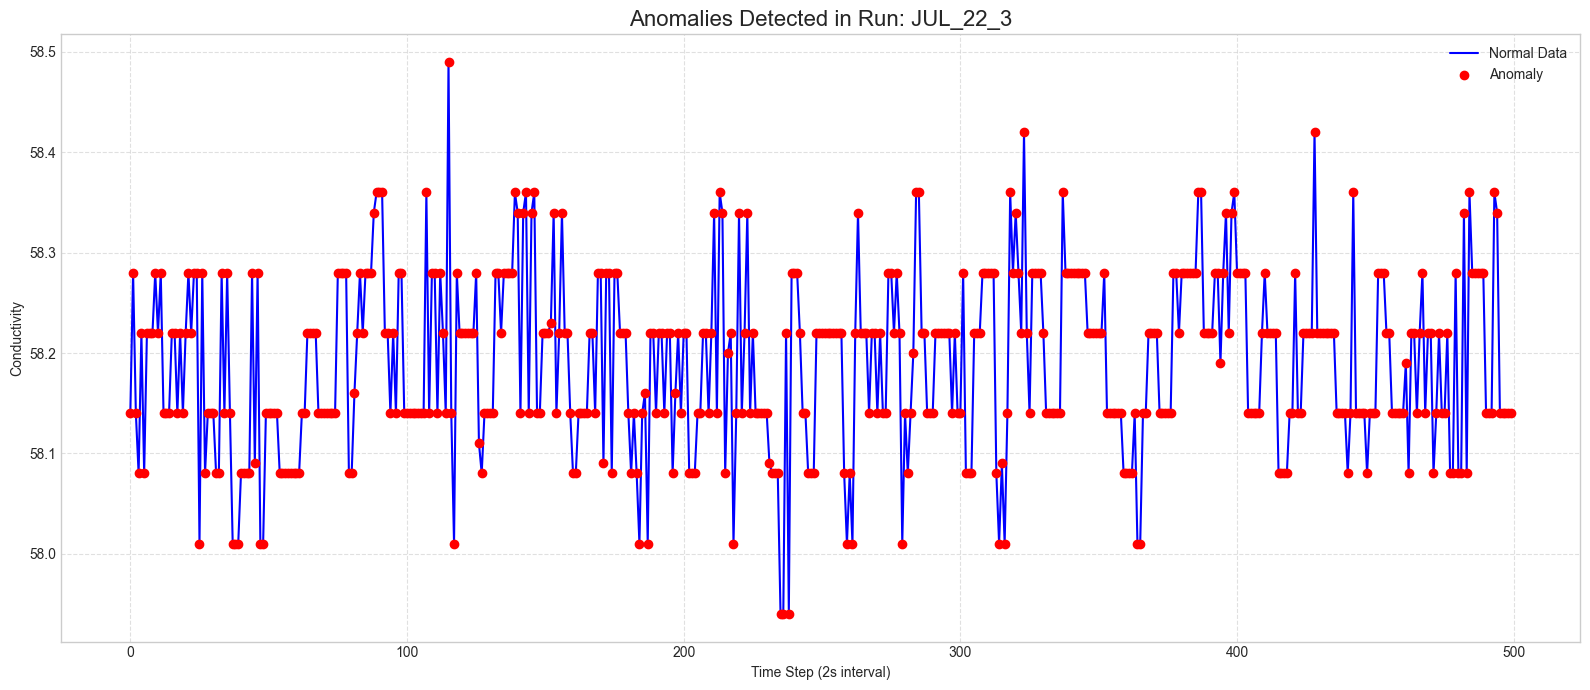

Anomaly Run 'JUL_22_3': Found 500 anomalous points after filtering (100.0%).
Generating simplified anomaly plot for anomaly run 'JUL_22_6'...


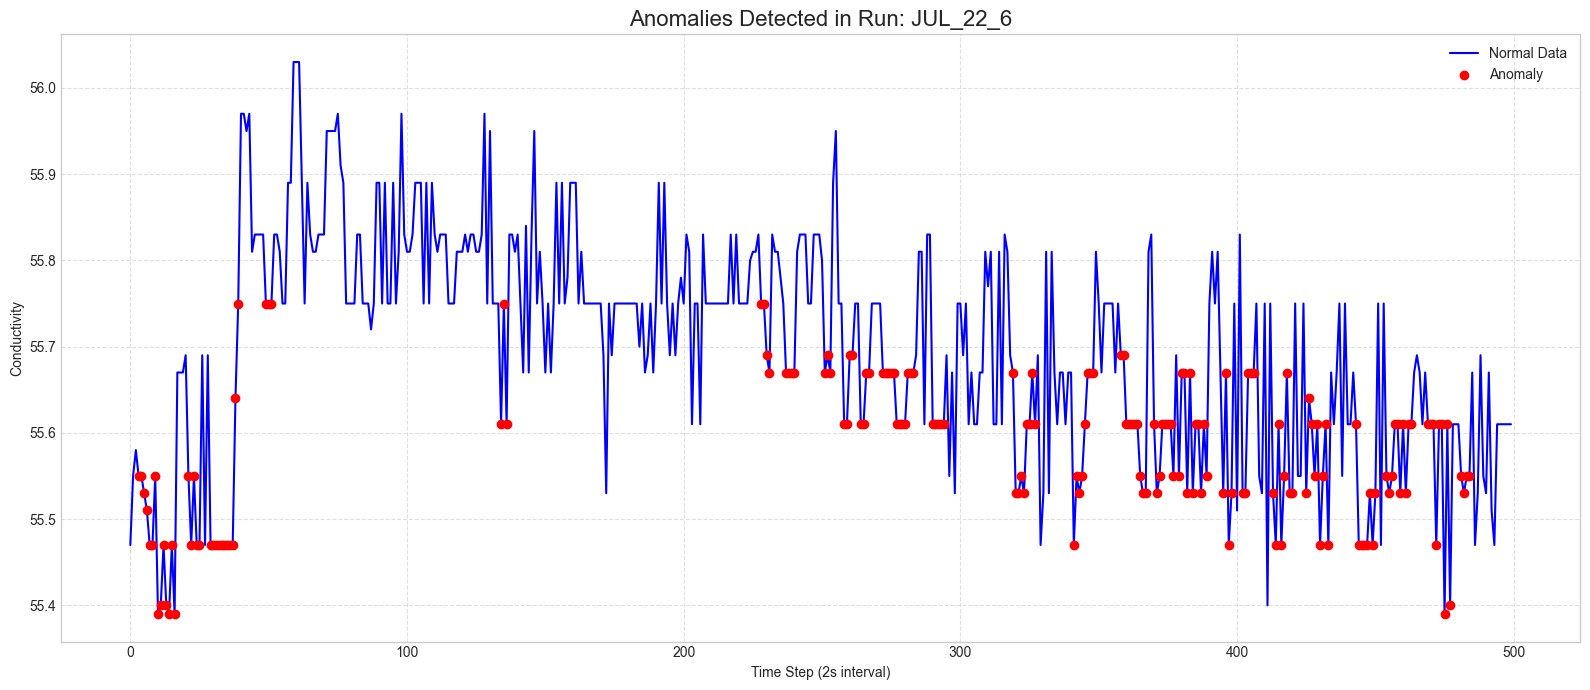

Anomaly Run 'JUL_22_6': Found 175 anomalous points after filtering (35.0%).
Generating simplified anomaly plot for anomaly run 'JUL_23_4'...


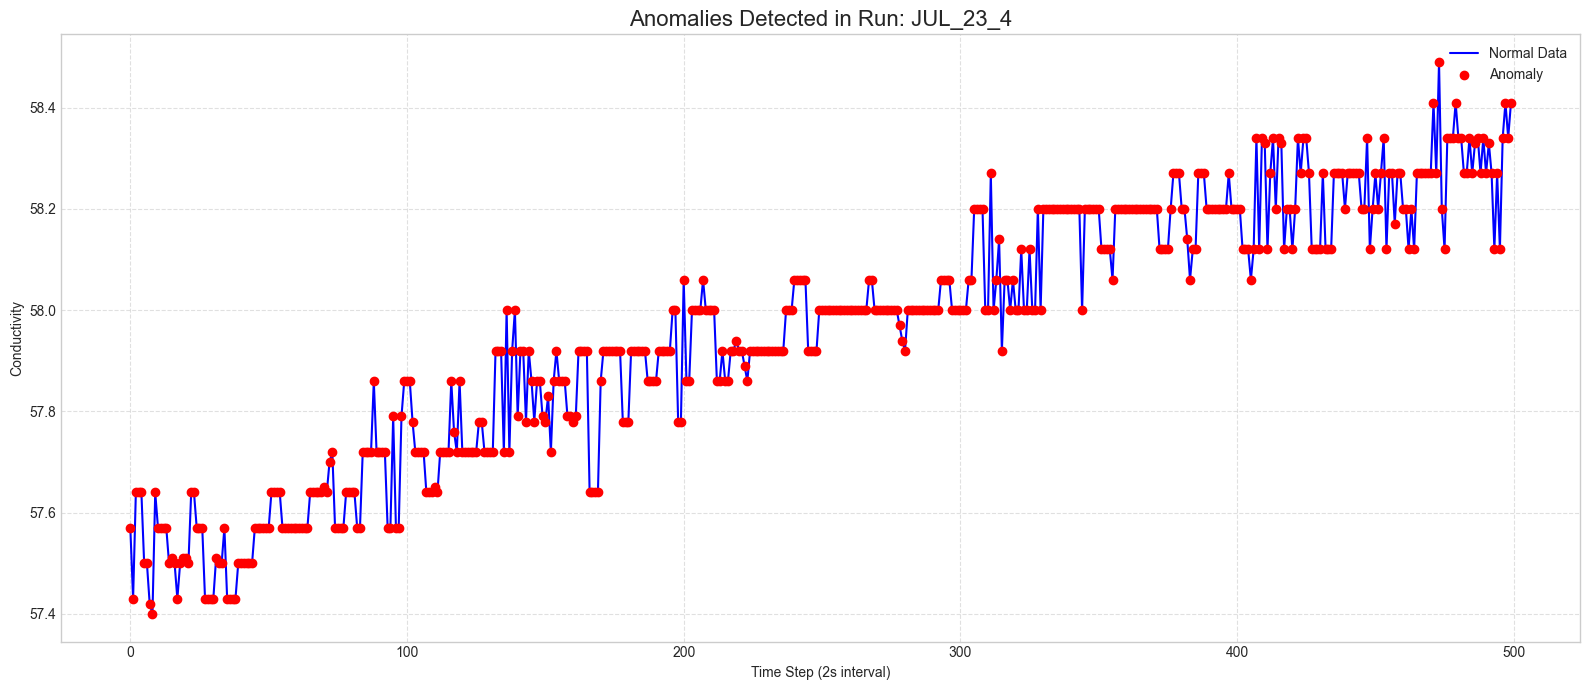

Anomaly Run 'JUL_23_4': Found 500 anomalous points after filtering (100.0%).
Generating simplified anomaly plot for anomaly run 'JUL_23_5'...


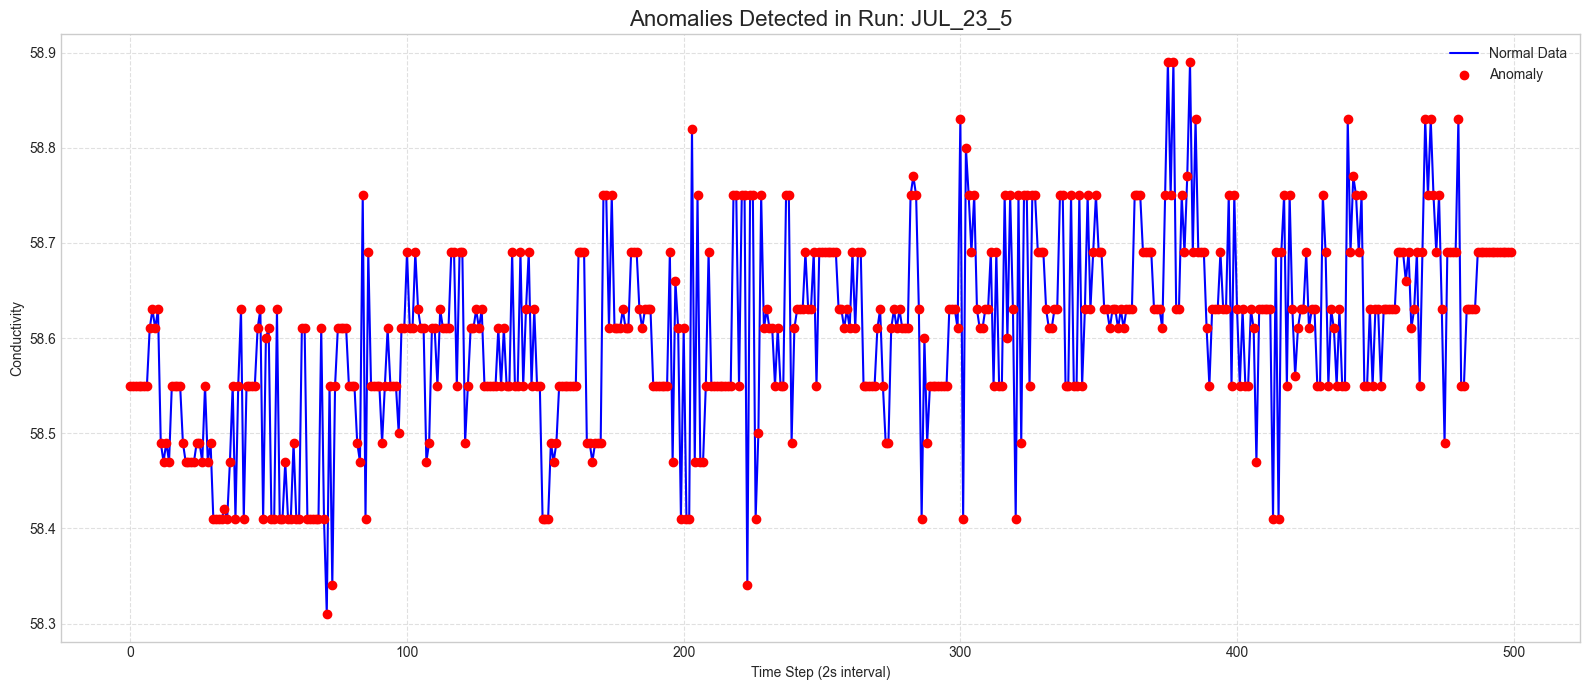

Anomaly Run 'JUL_23_5': Found 500 anomalous points after filtering (100.0%).
Generating simplified anomaly plot for anomaly run 'JUL_24_3'...


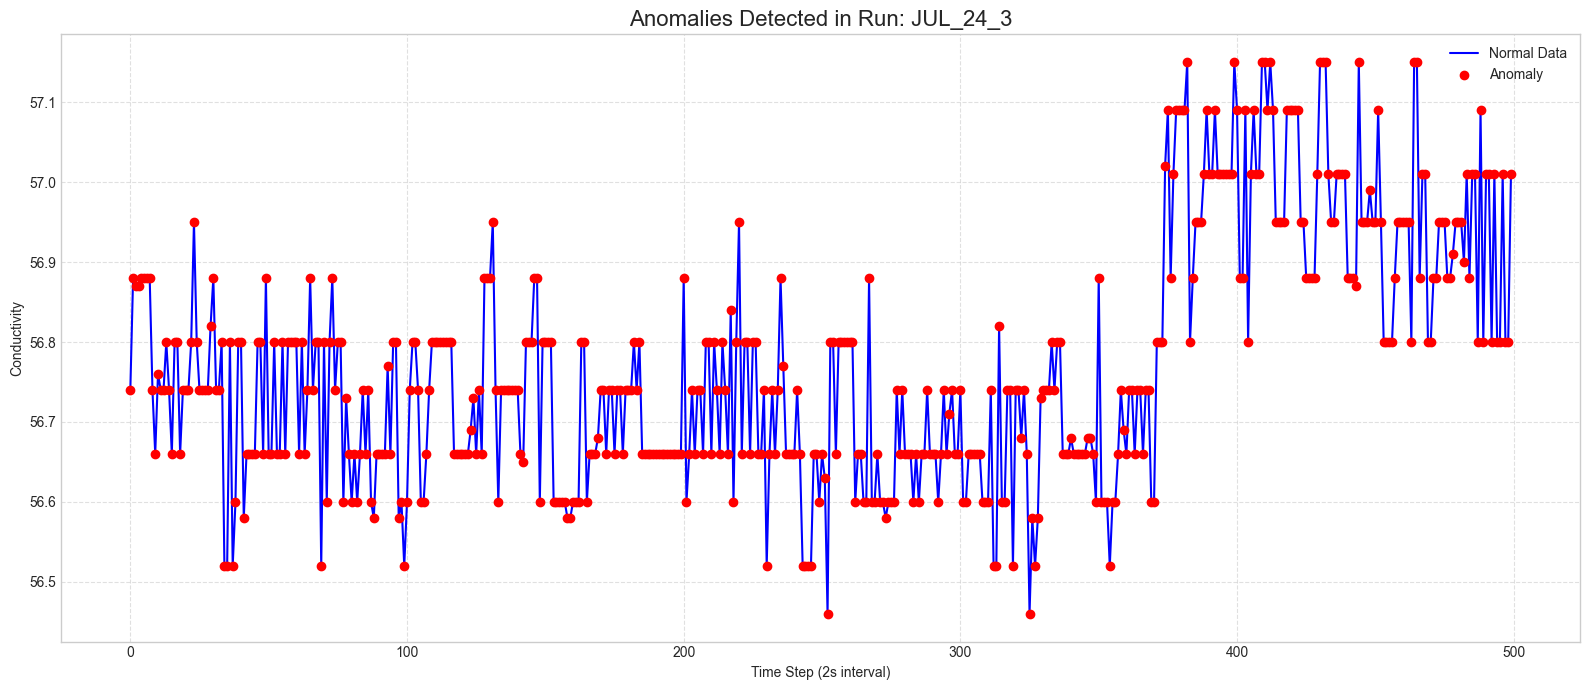

Anomaly Run 'JUL_24_3': Found 500 anomalous points after filtering (100.0%).
Generating simplified anomaly plot for anomaly run 'OCT_24_4'...


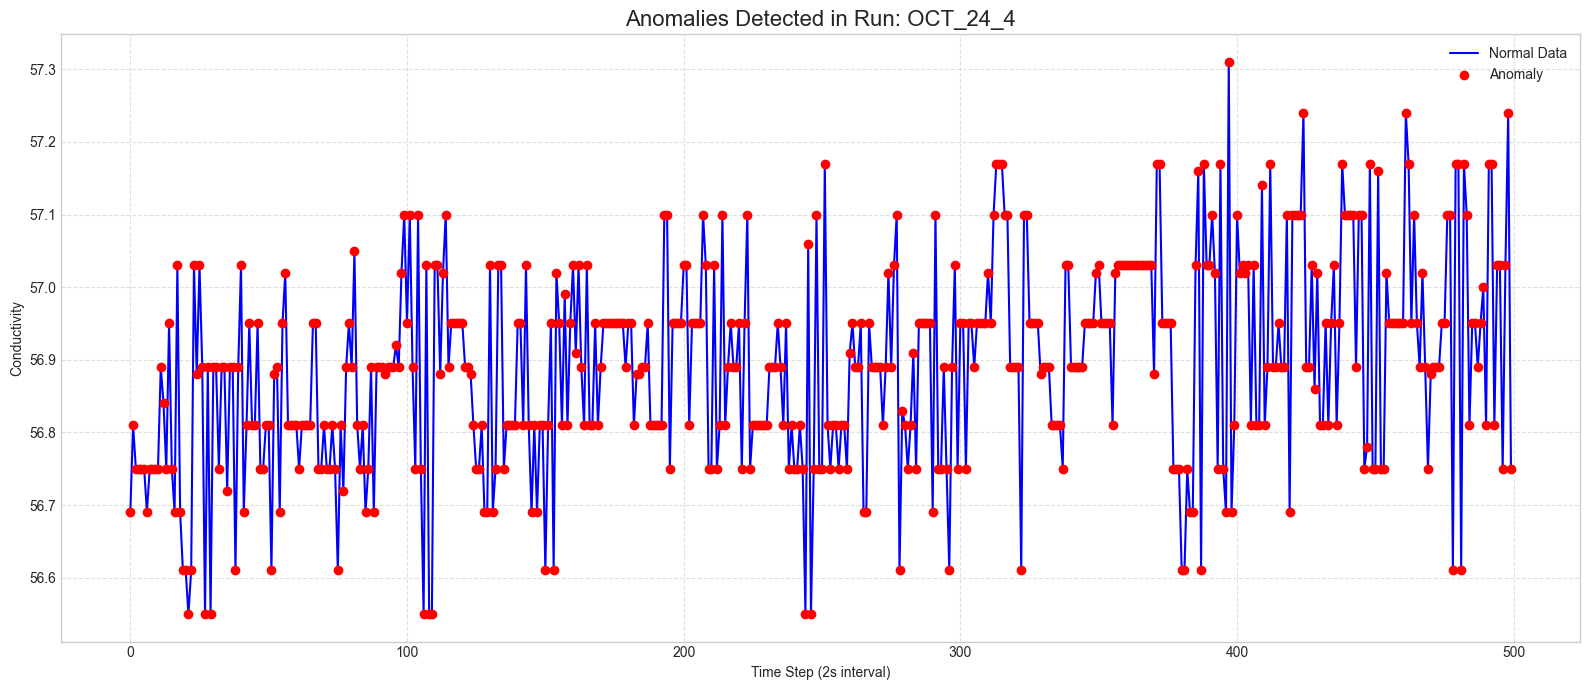

Anomaly Run 'OCT_24_4': Found 500 anomalous points after filtering (100.0%).


In [30]:
# --- 2. Data Preparation, Plotting & Anomaly Filtering Functions ---
def reconstruct_full_errors_from_windows(point_error_windows, original_length, window_size):
    """
    Reconstructs the full point-wise error signal from overlapping
    windows of point-wise errors.
    """
    reconstructed_error = np.zeros(original_length)
    window_counts = np.zeros(original_length)
    point_error_windows_float = point_error_windows.astype(np.float64)

    for i, window in enumerate(point_error_windows_float):
        start_index = i
        end_index = start_index + window_size
        if start_index >= original_length:
            break

        current_window_length = min(window_size,
                                  original_length - start_index)
        
        reconstructed_error[start_index:end_index] += window[
                                                     :current_window_length]
        window_counts[start_index:end_index] += 1

    window_counts[window_counts == 0] = 1
    return reconstructed_error / window_counts

def filter_consecutive_anomalies(is_anomalous, min_consecutive):
    """Filters a boolean array to only keep sequences of True values
    that are at least `min_consecutive` long."""
    filtered = np.zeros_like(is_anomalous)
    start_idx = -1
    for i, is_a in enumerate(is_anomalous):
        if is_a and start_idx == -1:
            start_idx = i
        elif not is_a and start_idx != -1:
            if (i - start_idx) >= min_consecutive:
                filtered[start_idx:i] = True
            start_idx = -1
    if start_idx != -1 and (len(is_anomalous) - start_idx) >= min_consecutive:
        filtered[start_idx:] = True
    return filtered

all_true_labels, all_predictions, all_scores_for_roc = [], [], []

# --- Create lists to store results for the big plot ---
all_run_signals = []
all_run_pred_masks = []
all_run_gt_masks = []
all_run_ids_list = []

unique_run_ids = anomaly_df['run_id'].unique()
for run_id in unique_run_ids:
    anomaly_run_df = anomaly_df[
        anomaly_df['run_id'] == run_id]
    original_signal = anomaly_run_df[TS_COLS].values.flatten()
    anomaly_windows = create_windows_from_featured_df(anomaly_run_df, TS_COLS, WINDOW_SIZE)
    if len(anomaly_windows) == 0:
        print(f"Warning: No windows created for run '{run_id}'. Skipping.")
        continue
    anomaly_windows_scaled = scaler.transform(anomaly_windows)
    anomaly_dataset = TimeSeriesWindowDataset(anomaly_windows_scaled)
    anomaly_loader = DataLoader(anomaly_dataset, batch_size=BATCH_SIZE, shuffle=False)
    reconstructed_windows_scaled, window_errors = get_reconstructions_and_errors(model, anomaly_loader)
    reconstructed_windows_unscaled = scaler.inverse_transform(reconstructed_windows_scaled)
    point_error_windows = (anomaly_windows - reconstructed_windows_unscaled)**2
    point_errors_full = reconstruct_full_errors_from_windows(point_error_windows, len(original_signal), WINDOW_SIZE)
    is_point_anomalous_raw = point_errors_full > threshold 
    y_pred_mask = filter_consecutive_anomalies(is_point_anomalous_raw,  CONSECUTIVE_WINDOW_THRESHOLD)
    print(f"Generating simplified anomaly plot for anomaly run '{run_id}'...")
    plot_anomalies(
        original_signal=original_signal,
        is_anomalous_mask=y_pred_mask,
        run_id=run_id
    )
    n_filtered_anomalous_points = np.sum(y_pred_mask)
    print(f"Anomaly Run '{run_id}': Found {n_filtered_anomalous_points} anomalous points after filtering ({n_filtered_anomalous_points / len(original_signal) * 100:.1f}%).")

    # --- (This part for ROC/Metrics is unchanged) ---
    y_score_mask = np.zeros(len(original_signal))
    for i, window_error in enumerate(window_errors):
        current_max = y_score_mask[i: i + WINDOW_SIZE]
        y_score_mask[i: i + WINDOW_SIZE] = np.maximum(current_max, window_error)

    current_ground_truth_mask = None
    label_row = anomaly_df_raw[(anomaly_df_raw['run_id'] == run_id) & (
            anomaly_df_raw['metric'] != 'conductivity')]
    if not label_row.empty:
        y_true_mask = (label_row[TS_COLS].values.flatten() == 1)
        if len(y_true_mask) == len(original_signal):
            current_ground_truth_mask = y_true_mask
            all_true_labels.extend(y_true_mask)
            all_predictions.extend(y_pred_mask)
            all_scores_for_roc.extend(y_score_mask)
        else:
            print(
                f"Warning: Length mismatch for run {run_id}. Ground truth: {len(y_true_mask)}, Original Signal: {len(original_signal)}. Skipping ground truth for this plot and overall metrics.")
    else:
        print(
            f"Warning: Could not find ground truth label row for run {run_id}. Skipping ground truth for this plot and overall metrics.")

    all_run_signals.append(original_signal)
    all_run_pred_masks.append(y_pred_mask)
    all_run_gt_masks.append(current_ground_truth_mask)
    all_run_ids_list.append(run_id)


Concatenating all test runs into a single graph...


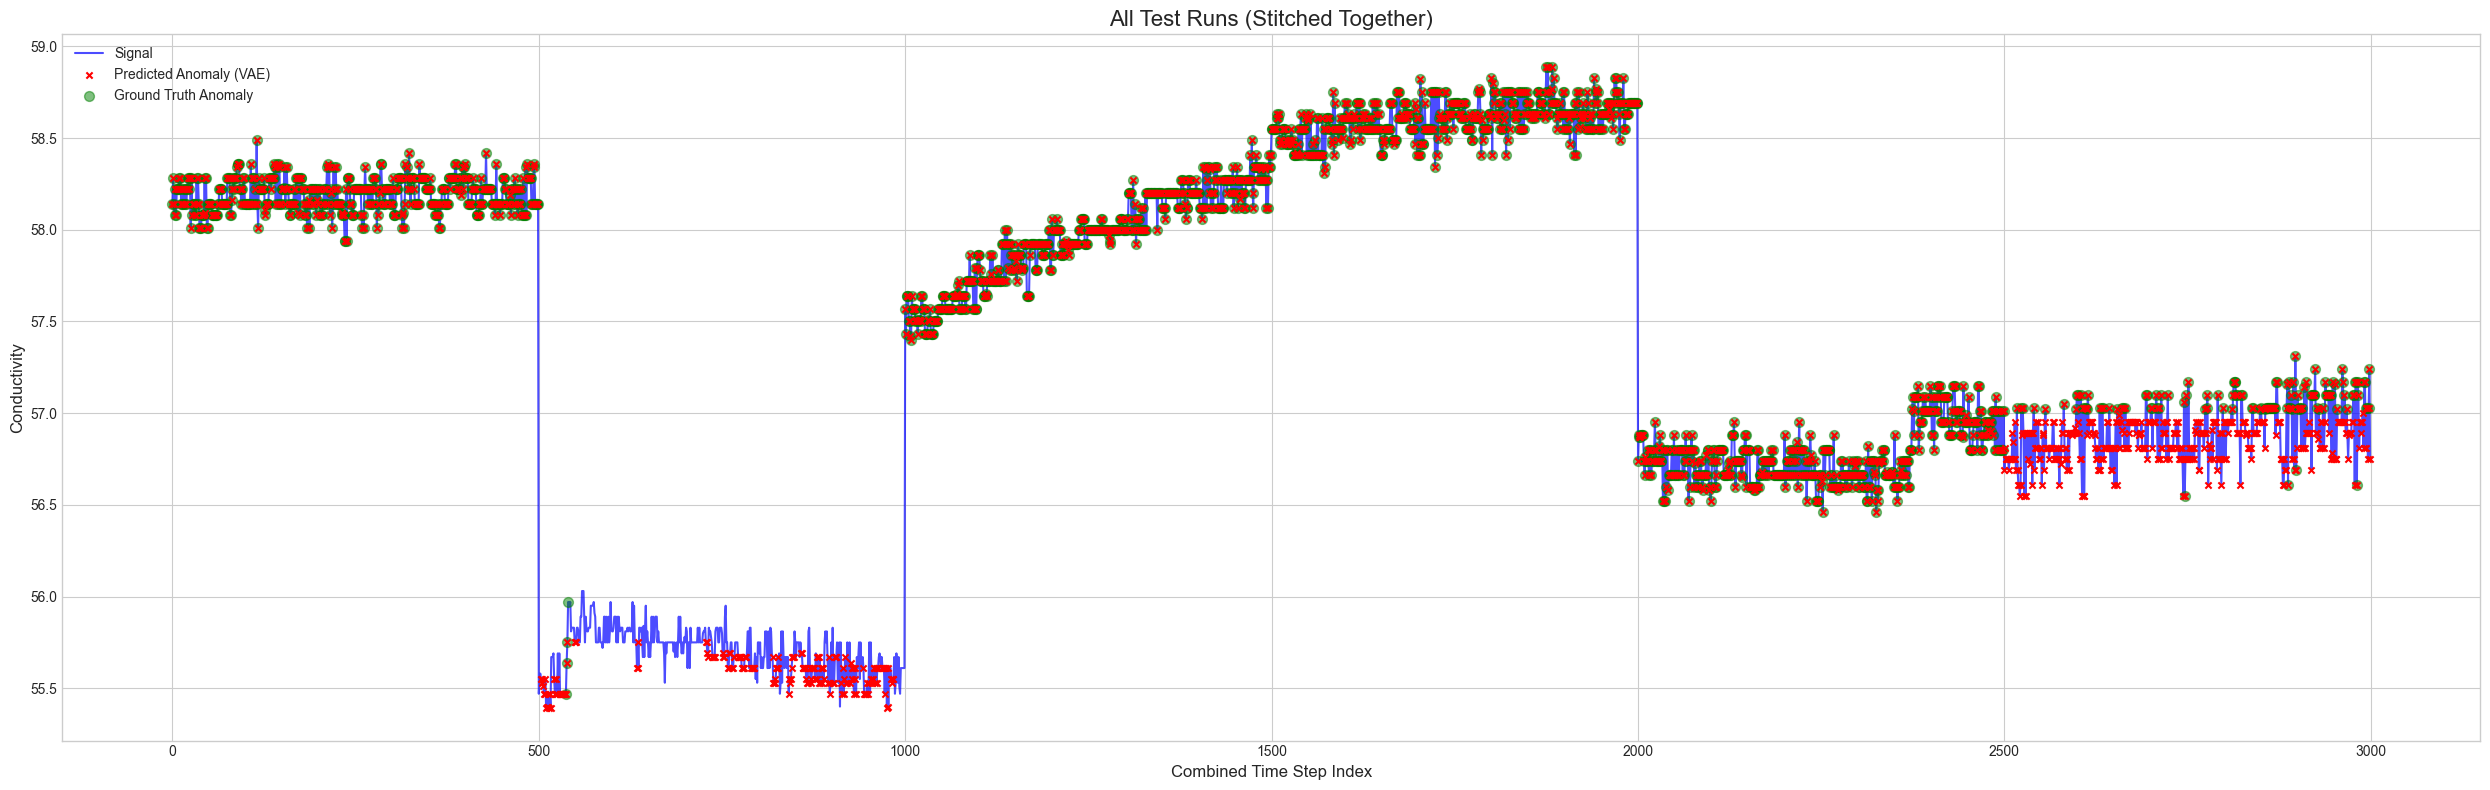

In [32]:
print("\nConcatenating all test runs into a single graph...")

# 1. Stitch all the signal arrays together
signals_stitched = np.concatenate(all_run_signals)

# 2. Stitch all the prediction mask arrays together
preds_stitched = np.concatenate(all_run_pred_masks)

# 3. Stitch all the ground truth arrays, handling 'None'
# (If a ground truth is 'None', we create a 'False' mask of the same length)
gt_stitched = np.concatenate([
    gt if gt is not None else np.zeros_like(all_run_signals[i], dtype=bool) 
    for i, gt in enumerate(all_run_gt_masks)
])

plot_anomalies_stitched(
    original_signal=signals_stitched,
    predicted_mask=preds_stitched,
    ground_truth_mask=gt_stitched,
    title="All Test Runs (Stitched Together)",
    x_label="Combined Time Step Index"
)
plt.show()


--- Overall Point-wise Confusion Matrix (Refined Model) ---


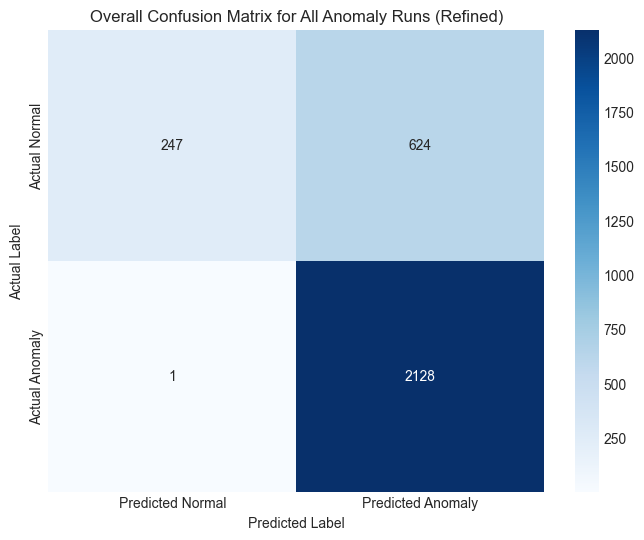


Overall Metrics:
  Accuracy: 0.7917
  Precision: 0.7733
  Recall: 0.9995
  F1-Score: 0.8720

--- Overall ROC Curve ---


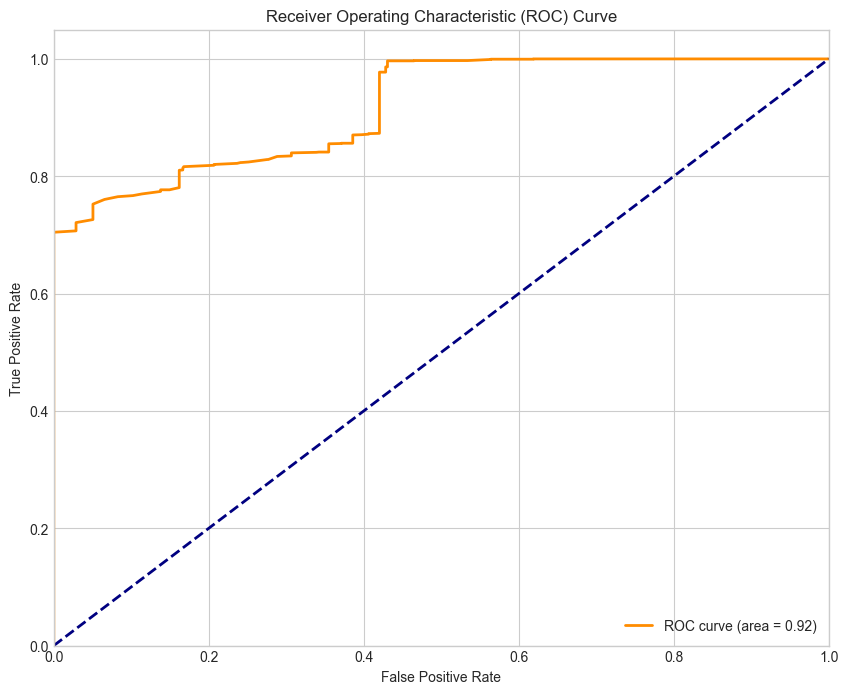

In [21]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

# --- 13. Overall Confusion Matrix ---
if all_true_labels and all_predictions:
    print("\n--- Overall Point-wise Confusion Matrix (Refined Model) ---")
    cm = confusion_matrix(all_true_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Normal', 'Predicted Anomaly'],
                yticklabels=['Actual Normal', 'Actual Anomaly'])
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Overall Confusion Matrix for All Anomaly Runs (Refined)')
    plt.show()

    # Calculate and print classification metrics
    accuracy, precision, recall, f1 = calculate_metrics(all_true_labels, all_predictions)
    print(f"\nOverall Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
else:
    print(
        "\nCould not generate a confusion matrix because no valid ground truth labels were found.")

# --- 14. Overall ROC Curve ---
if all_true_labels and all_scores_for_roc:
    print("\n--- Overall ROC Curve ---")
    fpr, tpr, thresholds = roc_curve(all_true_labels, all_scores_for_roc)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    print(
        "\nCould not generate an ROC curve because no valid ground truth labels or scores were found.")


--- Generating Latent Space Visualization (t-SNE) ---
Getting latent representations for normal (validation) data...
Getting latent representations for anomalous data...
Running t-SNE on 4239 samples (1413 normal, 2826 anomalous)...
Plotting t-SNE...


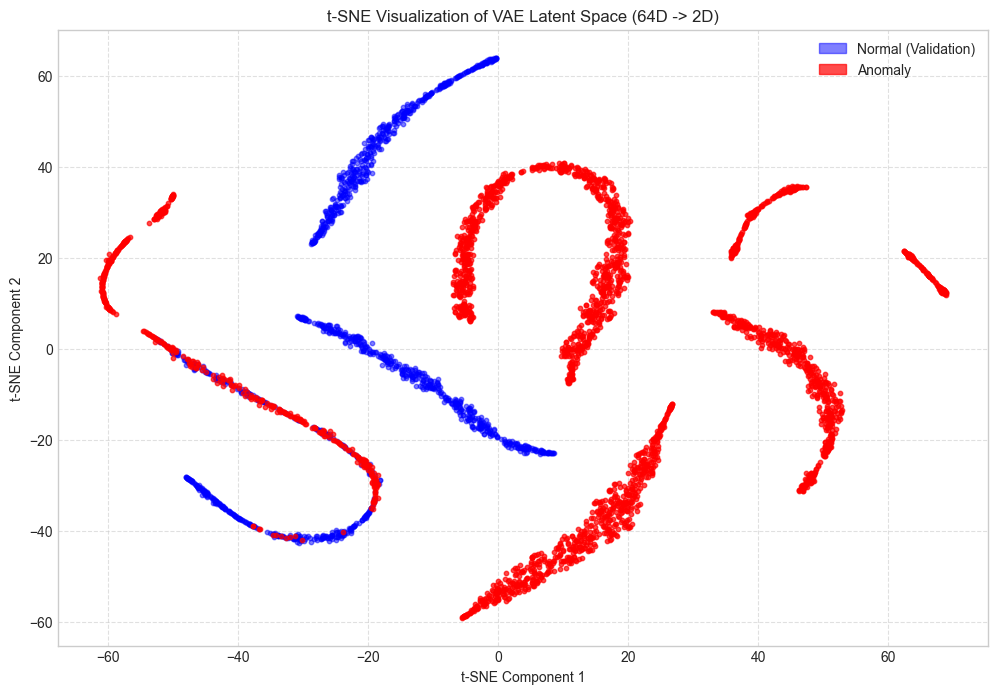

In [22]:
def get_latent_representations(model, dataloader):
    """
    Runs the dataloader through the VAE's encoder and returns all 
    latent mean (mu) vectors.
    """
    model.eval()
    all_latent_mu = []
    with torch.no_grad():
        for x in dataloader:
            x = x.to(DEVICE)
            # Pass data through encoder
            mu, log_var = model.encode(x)
            all_latent_mu.append(mu.cpu().numpy())
    
    return np.concatenate(all_latent_mu, axis=0)

# --- 15. Latent Space Visualization (t-SNE) ---
print("\n--- Generating Latent Space Visualization (t-SNE) ---")

# 1. Create a dataloader for ALL anomaly windows (not run-by-run)
anomaly_all_windows = create_windows_from_featured_df(anomaly_df, TS_COLS,
                                                      WINDOW_SIZE)
anomaly_all_windows_scaled = scaler.transform(anomaly_all_windows)
anomaly_all_dataset = TimeSeriesWindowDataset(anomaly_all_windows_scaled)
# Use a larger batch size for faster inference
anomaly_all_loader = DataLoader(anomaly_all_dataset, batch_size=BATCH_SIZE * 2, 
                                shuffle=False)

print("Getting latent representations for normal (validation) data...")
val_latent_vectors = get_latent_representations(model, val_loader)

print("Getting latent representations for anomalous data...")
anomaly_latent_vectors = get_latent_representations(model, anomaly_all_loader)

# 2. Sample data to keep t-SNE fast and balanced
max_points = 5000 # Max points per class to plot
n_val = len(val_latent_vectors)
n_anom = len(anomaly_latent_vectors)

val_indices = np.random.choice(n_val, size=min(max_points, n_val), replace=False)
anom_indices = np.random.choice(n_anom, size=min(max_points, n_anom), replace=False)

val_sample = val_latent_vectors[val_indices]
anom_sample = anomaly_latent_vectors[anom_indices]

# 3. Combine vectors and create labels
all_vectors = np.concatenate([val_sample, anom_sample], axis=0)
labels = np.array([0] * len(val_sample) + [1] * len(anom_sample))

print(f"Running t-SNE on {len(all_vectors)} samples ({len(val_sample)} normal, {len(anom_sample)} anomalous)...")
# Note: perplexity is a key param. 30-50 is a good default.
tsne = TSNE(n_components=2, perplexity=40, max_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(all_vectors)

# 4. Plot the results
print("Plotting t-SNE...")
val_2d = tsne_results[labels == 0]
anom_2d = tsne_results[labels == 1]

plt.figure(figsize=(12, 8))
plt.scatter(val_2d[:, 0], val_2d[:, 1], c='blue', alpha=0.5, s=10, 
            label='Normal (Validation)')
plt.scatter(anom_2d[:, 0], anom_2d[:, 1], c='red', alpha=0.7, s=10,
            label='Anomaly')

plt.title(f't-SNE Visualization of VAE Latent Space ({VAE_LATENT_DIM}D -> 2D)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Create a custom legend
blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='Normal (Validation)')
red_patch = mpatches.Patch(color='red', alpha=0.7, label='Anomaly')
plt.legend(handles=[blue_patch, red_patch])

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()